In [72]:
import pandas as pd
import numpy as np

In [74]:
df.head(2)

,Hash,Message,Filename,Source Code (prev),Source Code (current),Diff,LLM Inference,rectified message
0,b51eb87b4bce896550a647562a9526b34603eab9,Added possibility to write MOT compliant resul...,track.py,import argparse\nimport os\nimport platform\ni...,import argparse\nimport os\nimport platform\ni...,"@@ -114,6 +114,10 @@ def detect(opt, save_img=...",update webcam detection script,Added STORM - 236 to Changelog
1,21bc8b50d5727207b0fc2ca44f0cb2c98db9c542,Fixed video save bug,track.py,"from yolov5.utils.datasets import LoadImages, ...","from yolov5.utils.datasets import LoadImages, ...","@@ -50,11 +50,11 @@ def draw_boxes(img, bbox, ...",improve image detection,Add forced default for type to oCC 2


### Total number of commits

In [ ]:
print(f"Total number of hashes are {len(df["Hash"])}, while the unique number hashes are {df["Hash"].nunique()}")
print(f"Total number of Files are {df["Filename"].nunique()} which have changed in thim.")

Total number of hashes are 727, while the unique number hashes are 388
Total number of Files are 247 which have changed in them.


### Average number of files per commit

In [48]:
dict = {}
for index, row in df.iterrows():
    if row["Hash"] not in dict:
        dict[row["Hash"]] = 1
    else:
        dict[row["Hash"]] += 1

avg_value = 0

for _, count in dict.items():
    avg_value += count

avg_value /= len(dict)
print(f"Average number of modified files per commit: {avg_value}")
del dict

Average number of modified files per commit: 1.8737113402061856


In [49]:
import pandas as pd
from collections import defaultdict; 

fix_types = {
    "add": ["add", "create"],
    "update": ["update", "upgrade", "refactor", "restructure", "clean", "optimize", "improve", "enhance", "performance"],
    "remove": ["remove", "delete", "drop"],
    "fix": ["fix", "bug", "error", "correct"],
    "docs": ["docs", "documentation", "readme"],
    "test": ["test", "tests", "config", "build"]
}
mappings = {s2: m for m, s in fix_types.items() for s2 in s}
for m, s in fix_types.items():
    for s2 in s:
        mappings[s2] = m


def classify(commit_message):
    words = commit_message.lower().split()
    for word in words:
        if word in mappings:
            return [mappings[word]]
    return []

def counttype(df, column):
    count_lst = defaultdict(int)
    for msg in df[column].dropna():
        typematch = classify(msg)
        for t in typematch:
            count_lst[t] += 1
    return dict(count_lst)

counts = counttype(df, "LLM Inference")
print("Fix type distribution:", counts)

Fix type distribution: {'update': 497, 'add': 191, 'fix': 37, 'remove': 1}


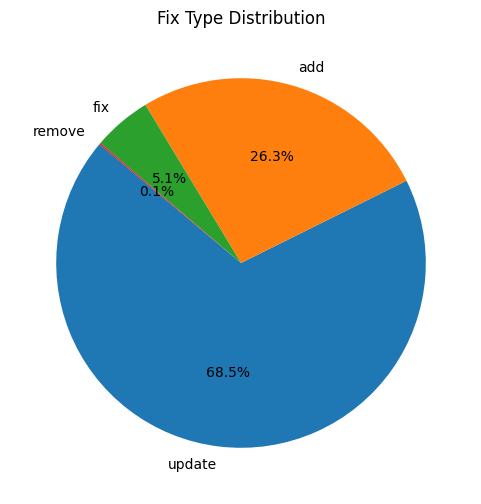

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%", startangle=140)
plt.title("Fix Type Distribution")
plt.show()

### Part - IV

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def extret(filename):
    return os.path.splitext(filename)[1] if "." in filename else "no_ext"

def freqmax(df, column="filename", top_n=10):
    files = df[column].dropna().tolist()
    file_counts = Counter(files)
    ext_counts = Counter(extret(f) for f in files)

    return file_counts.most_common(top_n), ext_counts.most_common(top_n)


file_counts, ext_counts = freqmax(df, column="Filename")

print("Top modified filenames:")
for f, c in file_counts:
    print(f"{f} → {c}")

print("\nTop modified extensions:")
for e, c in ext_counts:
    print(f"{e} → {c}")

📂 Top modified filenames:
tracking/val.py → 40
track.py → 32
boxmot/utils/__init__.py → 24
val.py → 14
boxmot/trackers/botsort/bot_sort.py → 14
boxmot/appearance/reid_export.py → 13
tracking/evolve.py → 13
.github/workflows/ci.yml → 11
boxmot/appearance/reid_multibackend.py → 11
boxmot/trackers/bytetrack/byte_tracker.py → 11

📝 Top modified extensions:
.py → 699
.yml → 14
.yaml → 6
 → 2
.toml → 2
.txt → 1
.gz → 1
.lock → 1
.md → 1


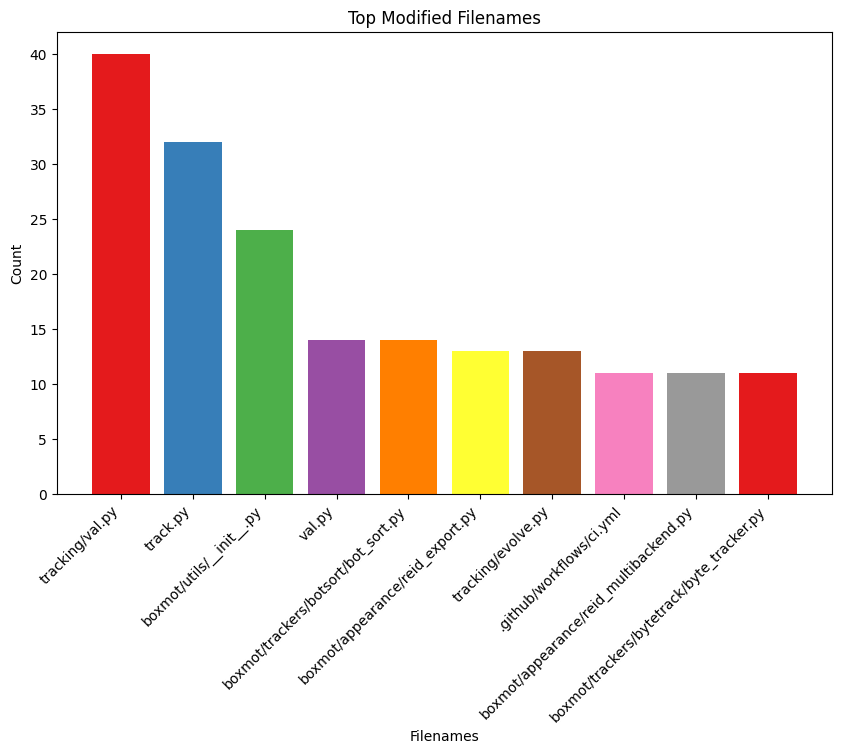

In [52]:
file_names, file_freqs = zip(*file_counts)

plt.figure(figsize=(10, 6))
plt.bar(file_names, file_freqs, color=plt.cm.Set1.colors)
plt.xticks(rotation=45, ha="right")
plt.title("Top Modified Filenames")
plt.xlabel("Filenames")
plt.ylabel("Count")
plt.show()

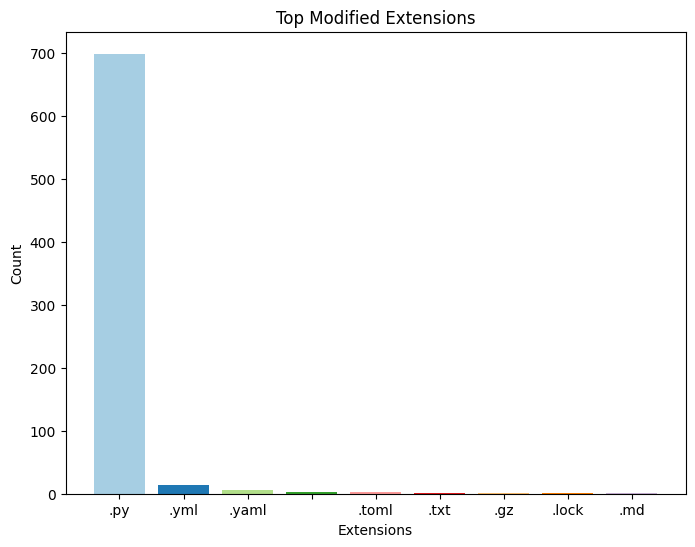

In [53]:
ext_names, ext_freqs = zip(*ext_counts)

plt.figure(figsize=(8, 6))
plt.bar(ext_names, ext_freqs, color=plt.cm.Paired.colors)
plt.title("Top Modified Extensions")
plt.xlabel("Extensions")
plt.ylabel("Count")
plt.show()

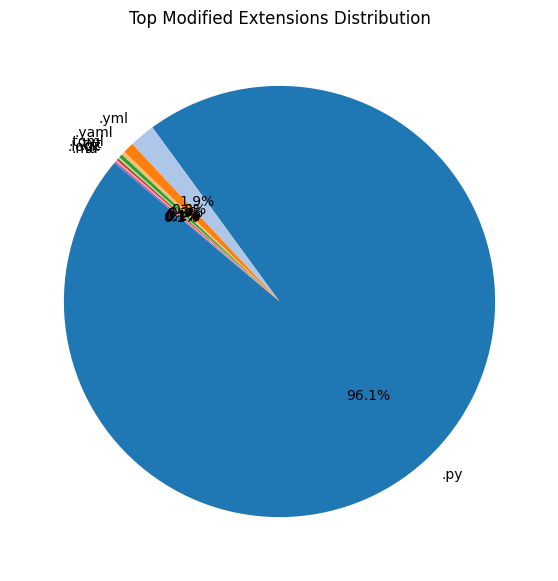

In [54]:
plt.figure(figsize=(7, 7))
plt.pie(ext_freqs, labels=ext_names, autopct="%1.1f%%", colors=plt.cm.tab20.colors, startangle=140)
plt.title("Top Modified Extensions Distribution")
plt.show()

# Part - c

### Only for python

In [ ]:
import pandas as pd; import numpy as np
from radon.raw import analyze as analyze_loc
from radon.metrics import mi_visit
from radon.complexity import cc_visit
import re, os, subprocess

REPO_PATH = "/Users/tejasmacipad/Desktop/Third_year/STT/lab2/boxmot"
df = pd.read_csv('diff.csv')

def codefetch(commit_hash, filepath, use_parent=False):
    git_spec = f"{commit_hash}^:{filepath}" if use_parent else f"{commit_hash}:{filepath}"
    command = ['git', 'show', git_spec]

    try:
        result = subprocess.run(
            command,
            cwd=REPO_PATH,
            capture_output=True,
            text=True,
            encoding='utf-8',
            errors='ignore',
            check=False
        )

        if result.returncode == 0:
            return result.stdout
        else:
            return ""
    except:
        print(f"error in {commit_hash} and {filepath}")

def radonmet(source_code):
    if not isinstance(source_code, str) or not source_code.strip():
        return np.nan, np.nan, np.nan

    cleaned_code = source_code.encode('ascii', 'ignore').decode('utf-8')

    try:
        loc = analyze_loc(cleaned_code).sloc
        mi = mi_visit(cleaned_code, multi=True)
        cc_results = cc_visit(cleaned_code)
        total_cc = sum(block.complexity for block in cc_results)
        return mi, total_cc, loc
    except Exception as e:
        return np.nan, np.nan, np.nan

metrics_before = []
metrics_after = []

for index, row in df.iterrows():

    commit_hash = row['Hash']
    filename = row['Filename']
    code_before = codefetch(commit_hash, filename, use_parent=True)
    code_after = codefetch(commit_hash, filename)
    metrics_before.append(radonmet(code_before))
    metrics_after.append(radonmet(code_after))

import pandas as pd
import numpy as np
from radon.metrics import mi_visit, analyze
from radon.complexity import cc_visit

csv_path = "diffprocessed.csv"
df = pd.read_csv(csv_path)

def radonmet(source_code):
    if not isinstance(source_code, str) or not source_code.strip():
        return np.nan, np.nan, np.nan
    cleaned_code = source_code.encode('ascii', 'ignore').decode('utf-8')
    try:
        loc = analyze(cleaned_code).sloc
        mi = mi_visit(cleaned_code, multi=True)
        cc_results = cc_visit(cleaned_code)
        total_cc = sum(block.complexity for block in cc_results)
        return mi, total_cc, loc
    except Exception:
        return np.nan, np.nan, np.nan

metrics_before = []
metrics_after = []

for index, row in df.iterrows():
    code_before = str(row["Source Code (prev)"])
    code_after = str(row["Source Code (current)"])
    metrics_before.append(radonmet(code_before))
    metrics_after.append(radonmet(code_after))


df[['MI_Before', 'CC_Before', 'LOC_Before']] = metrics_before
df[['MI_After', 'CC_After', 'LOC_After']] = metrics_after


df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']



display_cols = [
    'Hash', 'Filename', 'MI_Before', 'MI_After', 'MI_Change',
    'CC_Before', 'CC_After', 'CC_Change',
    'LOC_Before', 'LOC_After', 'LOC_Change'
]
if 'Filename' not in df.columns:
    display_cols.remove('Filename')

print(df[display_cols].to_string())
metric_cols = ['MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After','LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change']
cleaned_df = df.dropna(subset=metric_cols)
output_filename = 'diffprocessed.csv'
cleaned_df.to_csv(output_filename, index=False)

<unknown>:122: SyntaxWarning: invalid escape sequence '\D'
<unknown>:122: SyntaxWarning: invalid escape sequence '\D'
<unknown>:124: SyntaxWarning: invalid escape sequence '\D'
<unknown>:124: SyntaxWarning: invalid escape sequence '\D'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:290: SyntaxWarning: invalid escape sequence '\d'
<unknown>:290: SyntaxWarning: invalid escape sequence '\d'
<unknown>:274: SyntaxWarning: invalid escape sequence '\d'
<unknown>:274: SyntaxWarning: invalid escape sequence '\d'
<unknown>:216: SyntaxWarning: invalid escape sequence '\

                                         Hash                                                            Filename   MI_Before    MI_After  MI_Change  CC_Before  CC_After  CC_Change  LOC_Before  LOC_After  LOC_Change
0    b51eb87b4bce896550a647562a9526b34603eab9                                                            track.py   49.247687   49.771073   0.523386       42.0      41.0       -1.0       176.0      175.0        -1.0
1    21bc8b50d5727207b0fc2ca44f0cb2c98db9c542                                                            track.py   50.376505   49.521049  -0.855456       39.0      39.0        0.0       170.0      174.0         4.0
2    5fe232162fbc7d96b892e594f192c21793183b45                                                            track.py   48.137361   48.413938   0.276577       40.0      39.0       -1.0       196.0      195.0        -1.0
3    3b100c552af371b273b6679a72c63800f3afbf69                                                            track.py   48.000226   48.03728

## Part - C

In [5]:
import pandas as pd
import subprocess
from sentence_transformers import SentenceTransformer, util
import torch

repo_path = "/Users/tejasmacipad/Desktop/Third_year/STT/lab2/boxmot"
csv_path = "diffprocessed.csv"

df = pd.read_csv(csv_path)

model = SentenceTransformer("microsoft/codebert-base")
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

df["CodeBERT_Similarity"] = 0.0

def file_at_commit(commit_hash, filepath):
    if not commit_hash:
        return ""
    try:
        cmd = ["git", "-C", repo_path, "show", f"{commit_hash}:{filepath}"]
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            return result.stdout
    except Exception:
        pass
    return ""

for i, row in df.iterrows():
    h = str(row["Hash"])
    fname = str(row["Filename"])
    curr_code = file_at_commit(h, fname)
    parent_cmd = ["git", "-C", repo_path, "rev-list", "--parents", "-n", "1", h]
    result = subprocess.run(parent_cmd, stdout=subprocess.PIPE, text=True)
    parts = result.stdout.strip().split()
    parent_h = parts[1] if len(parts) > 1 else None
    prev_code = file_at_commit(parent_h, fname)
    emb = model.encode([prev_code, curr_code], convert_to_tensor=True, normalize_embeddings=True, device=device)
    sim = util.pytorch_cos_sim(emb[0], emb[1]).item()
    df.at[i, "CodeBERT_Similarity"] = float(sim)
    if i % 25 == 0:
        print(f"{i}/{len(df)}")

out_csv = "diffprocessed.csv"
df.to_csv(out_csv, index=False)
print("done ->", out_csv)

/Users/tejasmacipad/Desktop/Third_year/STT/Lab3/lab3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name microsoft/codebert-base. Creating a new one with mean pooling.


0/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

25/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

50/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

75/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

125/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

150/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

175/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

200/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

225/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

250/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

275/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

300/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

325/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

350/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

375/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

400/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

425/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

450/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

475/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

500/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

525/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

550/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

575/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

600/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

625/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

650/660


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

done -> diffprocessed.csv


In [2]:
import pandas as pd
temp2 = pd.read_csv("diffprocessed.csv")
temp2.columns

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message',
       'MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After',
       'LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change',
       'CodeBERT_Similarity', 'BLEU_Similarity', 'Semantic_class',
       'Classes_Agree', 'Token_class'],
      dtype='object')

In [5]:
print(f"Average of Maintainibility Index before: {temp2["MI_Before"].mean()}")
print(f"Average of Maintainibility Index after: {temp2["MI_After"].mean()}")
print(f"Average of Cyclomatic complexity before: {temp2["CC_Before"].mean()}")
print(f"Average of Cyclomatic complexity after: {temp2["CC_After"].mean()}")
print(f"Average of LOC before: {temp2["LOC_Before"].mean()}")
print(f"Average of LOC after: {temp2["LOC_After"].mean()}")

print(f"Average MI change: {temp2['MI_Change'].mean()}")
print(f"Average CC change: {temp2['CC_Change'].mean()}")
print(f"Average LOC change: {temp2['LOC_Change'].mean()}")

Average of Maintainibility Index before: 55.322437804822876
Average of Maintainibility Index after: 55.0618077795946
Average of Cyclomatic complexity before: 40.45757575757576
Average of Cyclomatic complexity after: 40.57272727272727
Average of LOC before: 178.80151515151516
Average of LOC after: 181.19545454545454
Average MI change: -0.2606300252282696
Average CC change: 0.11515151515151516
Average LOC change: 2.393939393939394


In [10]:
temp = pd.read_csv("diffprocessed.csv")
row = temp["CodeBERT_Similarity"]
print(row.mean())
row = temp["BLEU_Similarity"]
print(row.mean())

0.9995073082772168
0.9267267797885531


### Part - d

In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity

csv_path = "diffprocessed.csv"
df = pd.read_csv(csv_path)

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

df["CodeBERT_Similarity"] = 0.0

def get_codebert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embedding

for i, row in df.iterrows():
    prev_code = str(row["Source Code (prev)"])
    curr_code = str(row["Source Code (current)"])
    if prev_code.strip() and curr_code.strip():
        prev_emb = get_codebert_embedding(prev_code)
        curr_emb = get_codebert_embedding(curr_code)
        similarity = cosine_similarity(prev_emb, curr_emb)[0][0]
    else:
        similarity = 0.0
    df.at[i, "CodeBERT_Similarity"] = similarity
    if i % 25 == 0:
        print(f"{i}/{len(df)} processed...")

out_csv = "diffprocessed.csv"
df.to_csv(out_csv, index=False)

In [9]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download("punkt")

csv_path = "diffprocessed.csv"
df = pd.read_csv(csv_path)



df["BLEU_Similarity"] = 0.0

smooth_fn = SmoothingFunction().method1

for i, row in df.iterrows():
    prev_code = str(row["Source Code (prev)"])
    curr_code = str(row["Source Code (current)"])

    prev_tokens = prev_code.split()
    curr_tokens = curr_code.split()

    if prev_tokens and curr_tokens:
        bleu = sentence_bleu([prev_tokens], curr_tokens, smoothing_function=smooth_fn)
    else:
        bleu = 0.0

    df.at[i, "BLEU_Similarity"] = bleu

    if i % 25 == 0:
        print(f"{i}/{len(df)} processed...")

out_csv = "diffprocessed.csv"
df.to_csv(out_csv, index=False)
print("done ->", out_csv)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tejasmacipad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0/660 processed...
25/660 processed...
50/660 processed...
75/660 processed...
100/660 processed...
125/660 processed...
150/660 processed...
175/660 processed...
200/660 processed...
225/660 processed...
250/660 processed...
275/660 processed...
300/660 processed...
325/660 processed...
350/660 processed...
375/660 processed...
400/660 processed...
425/660 processed...
450/660 processed...
475/660 processed...
500/660 processed...
525/660 processed...
550/660 processed...
575/660 processed...
600/660 processed...
625/660 processed...
650/660 processed...
done -> diffprocessed.csv


In [8]:
df = pd.read_csv("diffprocessed.csv")
df.columns
df["BLEU_Similarity"].mean()

np.float64(0.9267267797885531)

### Part - e

In [ ]:
import pandas as pd

df["Semantic_class"] = df["Semantic_Similarity"].apply(
    lambda x: "Minor Fix" if x >= 0.80 else "Major Fix"
)
df["Token_class"] = df["Token_Similarity"].apply(
    lambda x: "Minor Fix" if x >= 0.75 else "Major Fix"
)
df["Classes_Agree"] = df.apply(
    lambda row: "YES" if row["Semantic_class"] == row["Token_class"] else "NO", axis=1
)

print(df[["Semantic_Similarity", "Token_Similarity", "Semantic_class", "Token_class", "Classes_Agree"]].head())

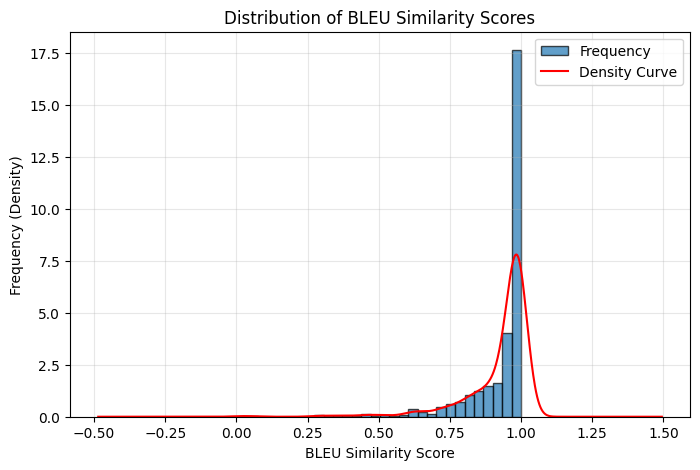

In [16]:
import matplotlib.pyplot as plt
temp = pd.read_csv("diffprocessed.csv").copy()
col = temp["BLEU_Similarity"]
plt.figure(figsize=(8,5))
plt.hist(col, bins=30, edgecolor="black", alpha=0.7, density=True, label="Frequency")
col.plot(kind="kde", color="red", label="Density Curve")
plt.xlabel("BLEU Similarity Score")
plt.ylabel("Frequency (Density)")
plt.title("Distribution of BLEU Similarity Scores")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [5]:
import pandas as pd

df = pd.read_csv("diffprocessed.csv").copy()
cutoff = 0.97
df["Semantic_class"] = df["BLEU_Similarity"].apply(lambda x: "High" if x <= cutoff else "Low")
df["Token_class"] = df["CodeBERT_Similarity"].apply(lambda x: "High" if x <= cutoff else "Low")
df.to_csv("diffprocessed.csv", index=False)

In [6]:
df.to_csv("diffprocessed.csv", index=False)
print(df.columns)

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message',
       'MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After',
       'LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change',
       'CodeBERT_Similarity', 'BLEU_Similarity', 'Semantic_class',
       'Classes_Agree', 'Token_class'],
      dtype='object')


In [7]:
import pandas as pd
df = pd.read_csv("diffprocessed.csv")
df.columns

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message',
       'MI_Before', 'CC_Before', 'LOC_Before', 'MI_After', 'CC_After',
       'LOC_After', 'MI_Change', 'CC_Change', 'LOC_Change',
       'CodeBERT_Similarity', 'BLEU_Similarity', 'Semantic_class',
       'Classes_Agree', 'Token_class'],
      dtype='object')

In [ ]:
import pandas as pd
df = pd.read_csv("diffprocessed.csv")
df["Classes_Agree"] = df.apply(
    lambda row: "YES" if row["Semantic_class"] == row["Token_class"] else "NO",
    axis=1
)
# df.to_csv("diffprocessed.csv", index=False)

print(df[["Semantic_class", "Token_class", "Classes_Agree"]].head())
print(f"Number of commits which are major according to CodeBERT Model {(df["Token_class"] == "High").sum()}")
print(f"Number of commits which are major according to Bleu Tokens {(df["Semantic_class"] == "High").sum()}")
print(f"Number of commits where methods agree {(df["Classes_Agree"] == "YES").sum()}")


  Semantic_class Token_class Classes_Agree
0           High         Low            NO
1           High         Low            NO
2            Low         Low           YES
3            Low         Low           YES
4           High         Low            NO
Number of commits which are major according to CodeBERT Model 37
Number of commits which are major according to Bleu Tokens 291
Number of commits where methods agree 341


### Backup - Main

In [ ]:

print(f"Number of commits which are major according to CodeBERT Model 37")
print(f"Number of commits which are major according to Bleu Tokens {(df["Semantic_class"] == "High").sum()}")
print(f"Number of commits where methods agree 341")

Final code which runs

In [ ]:
import pandas as pd; import numpy as np
from radon.raw import analyze as analyze_loc
from radon.metrics import mi_visit
from radon.complexity import cc_visit
import re, os, subprocess

REPO_PATH = "/Users/tejasmacipad/Desktop/Third_year/STT/lab2/boxmot"
df_raw = pd.read_csv('diff.csv')

def codefetch(commit_hash, filepath, use_parent=False):
    git_spec = f"{commit_hash}^:{filepath}" if use_parent else f"{commit_hash}:{filepath}"
    command = ['git', 'show', git_spec]

    try:
        result = subprocess.run(
            command,
            cwd=REPO_PATH,
            capture_output=True,
            text=True,
            encoding='utf-8',
            errors='ignore',
            check=False
        )

        if result.returncode == 0:
            return result.stdout
        else:
            return ""
    except:
        print(f"error in {commit_hash} and {filepath}")

def radonmet(source_code):
    if not isinstance(source_code, str) or not source_code.strip():
        print("DEBUG: Source code is empty or not a string. Returning NaN for metrics.")
        return np.nan, np.nan, np.nan

    cleaned_code = source_code.encode('ascii', 'ignore').decode('utf-8')

    try:
        loc = analyze_loc(cleaned_code).sloc
        mi = mi_visit(cleaned_code, multi=True)
        cc_results = cc_visit(cleaned_code)
        total_cc = sum(block.complexity for block in cc_results)
        return mi, total_cc, loc
    except Exception as e:
        print(f"DEBUG: Radon could not parse the code. Error: {e}. Returning NaN for metrics.")
        return np.nan, np.nan, np.nan

metrics_before = []
metrics_after = []

for index, row in df.iterrows():

    commit_hash = row['Hash']
    filename = row['Filename']
    code_before = codefetch(commit_hash, filename, use_parent=True)
    code_after = codefetch(commit_hash, filename)
    metrics_before.append(radonmet(code_before))
    metrics_after.append(radonmet(code_after))

df[['MI_Before', 'CC_Before', 'LOC_Before']] = metrics_before
df[['MI_After', 'CC_After', 'LOC_After']] = metrics_after


df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']


display_cols = [
    'Hash', 'Filename', 'MI_Before', 'MI_After', 'MI_Change',
    'CC_Before', 'CC_After', 'CC_Change',
    'LOC_Before', 'LOC_After', 'LOC_Change'
]
if 'Filename' not in df.columns:
    display_cols.remove('Filename')

print(df[display_cols].to_string())

output_filename = 'diffprocessed.csv'
df.to_csv(output_filename, index=False)

In [71]:
temp = pd.read_csv("df_with_bleu.csv")
print(temp.columns)

Index(['Hash', 'Message', 'Filename', 'Source Code (prev)',
       'Source Code (current)', 'Diff', 'LLM Inference', 'rectified message',
       'BLEU_Similarity'],
      dtype='object')


In [ ]:
import pandas as pd; import numpy as np
from radon.raw import analyze as analyze_loc
from radon.metrics import mi_visit
from radon.complexity import cc_visit
import re, os, subprocess

REPO_PATH = "/Users/tejasmacipad/Desktop/Third_year/STT/lab2/boxmot"
df_raw = pd.read_csv('diff.csv')


df = df_raw[df_raw['Filename'].astype(str).str.endswith('.py')].copy()
print(f"filtering python files")

def fetch_code_from_git(commit_hash, filepath, use_parent=False):
    git_spec = f"{commit_hash}^:{filepath}" if use_parent else f"{commit_hash}:{filepath}"
    command = ['git', 'show', git_spec]

    try:
        result = subprocess.run(
            command,
            cwd=REPO_PATH,
            capture_output=True,
            text=True,
            encoding='utf-8',
            errors='ignore',
            check=False
        )

        if result.returncode == 0:
            return result.stdout
        else:
            return ""
    except:
        print(f"error in {commit_hash} and {filepath}")

def get_radon_metrics(source_code):
    if not isinstance(source_code, str) or not source_code.strip():
        print("DEBUG: Source code is empty or not a string. Returning NaN for metrics.")
        return np.nan, np.nan, np.nan

    cleaned_code = source_code.encode('ascii', 'ignore').decode('utf-8')

    try:
        loc = analyze_loc(cleaned_code).sloc
        mi = mi_visit(cleaned_code, multi=True)
        cc_results = cc_visit(cleaned_code)
        total_cc = sum(block.complexity for block in cc_results)
        return mi, total_cc, loc
    except Exception as e:
        print(f"DEBUG: Radon could not parse the code. Error: {e}. Returning NaN for metrics.")
        return np.nan, np.nan, np.nan

metrics_before = []
metrics_after = []

for index, row in df.iterrows():

    commit_hash = row['Hash']
    filename = row['Filename']
    code_before = fetch_code_from_git(commit_hash, filename, use_parent=True)
    code_after = fetch_code_from_git(commit_hash, filename)
    mi_b, cc_b, loc_b = get_radon_metrics(code_before)
    metrics_before.append((mi_b, cc_b, loc_b))
    mi_a, cc_a, loc_a = get_radon_metrics(code_after)
    metrics_after.append((mi_a, cc_a, loc_a))


df[['MI_Before', 'CC_Before', 'LOC_Before']] = metrics_before
df[['MI_After', 'CC_After', 'LOC_After']] = metrics_after

# --- 7. Compute the change columns ---
df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']


# --- 8. Display the final result ---
print("--- Final DataFrame with Structural Metrics ---")
display_cols = [
    'Hash', 'Filename', 'MI_Before', 'MI_After', 'MI_Change',
    'CC_Before', 'CC_After', 'CC_Change',
    'LOC_Before', 'LOC_After', 'LOC_Change'
]
if 'Filename' not in df.columns:
    display_cols.remove('Filename')

print(df[display_cols].to_string())

output_filename = 'diffprocessed.csv'
df.to_csv(output_filename, index=False)

filtering python files


<unknown>:122: SyntaxWarning: invalid escape sequence '\D'
<unknown>:122: SyntaxWarning: invalid escape sequence '\D'
<unknown>:124: SyntaxWarning: invalid escape sequence '\D'
<unknown>:124: SyntaxWarning: invalid escape sequence '\D'


DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for m

<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:160: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:161: SyntaxWarning: invalid escape sequence '\d'
<unknown>:290: SyntaxWarning: invalid escape sequence '\d'
<unknown>:290: SyntaxWarning: invalid escape sequence '\d'
<unknown>:274: SyntaxWarning: invalid escape sequence '\d'
<unknown>:274: SyntaxWarning: invalid escape sequence '\d'
<unknown>:216: SyntaxWarning: invalid escape sequence '\D'
<unknown>:216: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'


DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:125: SyntaxWarning: invalid escape sequence '\D'
<unknown>:125: SyntaxWarning: invalid escape sequence '\D'
<unknown>:125: SyntaxWarning: invalid escape sequence '\D'
<unknown>:125: SyntaxWarning: invalid escape sequence '\D'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:275: SyntaxWarning: invalid escape sequence '\d'
<unknown>:280: SyntaxWarning: invalid escape sequence '\d'
<unknown>:280: SyntaxWarning: invalid escape sequence '\d'
<unknown>:278: SyntaxWarning: invalid escape sequence '\d'
<unknown>:278: SyntaxWarning: invalid escape sequence '\d'
<unknown>:280: SyntaxWarning: invalid escape sequence '\

DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:279: SyntaxWarning: invalid escape sequence '\d'
<unknown>:279: SyntaxWarning: invalid escape sequence '\d'
<unknown>:279: SyntaxWarning: invalid escape sequence '\d'
<unknown>:279: SyntaxWarning: invalid escape sequence '\d'
<unknown>:278: SyntaxWarning: invalid escape sequence '\d'
<unknown>:278: SyntaxWarning: invalid escape sequence '\d'
<unknown>:278: SyntaxWarning: invalid escape sequence '\d'
<unknown>:278: SyntaxWarning: invalid escape sequence '\d'
<unknown>:211: SyntaxWarning: invalid escape sequence '\D'
<unknown>:211: SyntaxWarning: invalid escape sequence '\D'
<unknown>:213: SyntaxWarning: invalid escape sequence '\D'
<unknown>:213: SyntaxWarning: invalid escape sequence '\D'
<unknown>:291: SyntaxWarning: invalid escape sequence '\d'
<unknown>:291: SyntaxWarning: invalid escape sequence '\d'
<unknown>:294: SyntaxWarning: invalid escape sequence '\d'
<unknown>:294: SyntaxWarning: invalid escape sequence '\d'
<unknown>:212: SyntaxWarning: invalid escape sequence '\

DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:120: SyntaxWarning: invalid escape sequence '\D'
<unknown>:120: SyntaxWarning: invalid escape sequence '\D'
<unknown>:142: SyntaxWarning: invalid escape sequence '\D'
<unknown>:142: SyntaxWarning: invalid escape sequence '\D'
<unknown>:276: SyntaxWarning: invalid escape sequence '\d'
<unknown>:276: SyntaxWarning: invalid escape sequence '\d'
<unknown>:274: SyntaxWarning: invalid escape sequence '\d'
<unknown>:274: SyntaxWarning: invalid escape sequence '\d'


DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:144: SyntaxWarning: invalid escape sequence '\D'
<unknown>:212: SyntaxWarning: invalid escape sequence '\

DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:280: SyntaxWarning: invalid escape sequence '\d'
<unknown>:280: SyntaxWarning: invalid escape sequence '\d'
<unknown>:280: SyntaxWarning: invalid escape sequence '\d'
<unknown>:280: SyntaxWarning: invalid escape sequence '\d'
<unknown>:285: SyntaxWarning: invalid escape sequence '\d'
<unknown>:285: SyntaxWarning: invalid escape sequence '\d'
<unknown>:286: SyntaxWarning: invalid escape sequence '\d'
<unknown>:286: SyntaxWarning: invalid escape sequence '\d'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'


DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'
<unknown>:146: SyntaxWarning: invalid escape sequence '\D'


DEBUG: Source code is empty or not a string. Returning NaN for metrics.
error in f9b7841954a4e5fed0144c781960e2adc0aa0e2c and experimentation/utils.py
DEBUG: Source code is empty or not a string. Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:29: SyntaxWarning: invalid escape sequence '\d'
<unknown>:29: SyntaxWarning: invalid escape sequence '\d'
<unknown>:29: SyntaxWarning: invalid escape sequence '\d'
<unknown>:29: SyntaxWarning: invalid escape sequence '\d'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:149: SyntaxWarning: invalid escape sequence '\D'
<unknown>:149: SyntaxWarning: invalid escape sequence '\D'
<unknown>:148: SyntaxWarning: invalid escape sequence '\D'
<unknown>:148: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'
<unknown>:219: SyntaxWarning: invalid escape sequence '\D'


DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:218: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'
<unknown>:152: SyntaxWarning: invalid escape sequence '\D'


DEBUG: Radon could not parse the code. Error: unmatched '}' (<unknown>, line 3). Returning NaN for metrics.
DEBUG: Radon could not parse the code. Error: closing parenthesis '}' does not match opening parenthesis '(' (<unknown>, line 174). Returning NaN for metrics.
DEBUG: Radon could not parse the code. Error: closing parenthesis '}' does not match opening parenthesis '(' (<unknown>, line 174). Returning NaN for metrics.
DEBUG: Radon could not parse the code. Error: closing parenthesis '}' does not match opening parenthesis '(' (<unknown>, line 177). Returning NaN for metrics.
DEBUG: Radon could not parse the code. Error: closing parenthesis '}' does not match opening parenthesis '(' (<unknown>, line 177). Returning NaN for metrics.


<unknown>:29: SyntaxWarning: invalid escape sequence '\d'
<unknown>:29: SyntaxWarning: invalid escape sequence '\d'
<unknown>:30: SyntaxWarning: invalid escape sequence '\d'
<unknown>:30: SyntaxWarning: invalid escape sequence '\d'
<unknown>:30: SyntaxWarning: invalid escape sequence '\d'
<unknown>:30: SyntaxWarning: invalid escape sequence '\d'
<unknown>:30: SyntaxWarning: invalid escape sequence '\d'
<unknown>:30: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: SyntaxWarning: invalid escape sequence '\d'
<unknown>:31: 

DEBUG: Radon could not parse the code. Error: unexpected indent (<unknown>, line 1). Returning NaN for metrics.
DEBUG: Source code is empty or not a string. Returning NaN for metrics.


<unknown>:303: SyntaxWarning: invalid escape sequence '\d'
<unknown>:303: SyntaxWarning: invalid escape sequence '\d'
<unknown>:303: SyntaxWarning: invalid escape sequence '\d'
<unknown>:303: SyntaxWarning: invalid escape sequence '\d'
<unknown>:303: SyntaxWarning: invalid escape sequence '\d'
<unknown>:303: SyntaxWarning: invalid escape sequence '\d'


#### Old backup

In [ ]:
import pandas as pd
from radon.raw import analyze as analyze_loc
from radon.metrics import mi_visit
from radon.complexity import cc_visit
import numpy as np
import re

# --- 1. Load Your DataFrame ---
# Replace 'your_dataset.csv' with the actual path to your data file.
print("--- Loading data from CSV file ---")
df_raw = pd.read_csv('diff.csv').copy()
print(f"DataFrame loaded successfully with {len(df_raw)} total rows.\n")

# --- 2. Filter for Python files only ---
# This is a more efficient approach than checking in the loop.
print("--- Filtering for Python (.py) files ---")
# Ensure 'Filename' is a string before using .str accessor
df = df_raw[df_raw['Filename'].astype(str).str.endswith('.py')].copy()
print(f"Filtered down to {len(df)} Python files.\n")


# --- 3. Define a function to get all radon metrics ---
def get_radon_metrics(source_code):
    """
    Calculates key metrics for a given Python source code string using radon.
    Handles potential SyntaxErrors and formatting issues in the input code.

    Args:
        source_code (str): A string containing the Python source code.

    Returns:
        tuple: A tuple containing (Maintainability Index, Total Cyclomatic Complexity, Source Lines of Code).
               Returns (np.nan, np.nan, np.nan) for empty or invalid/unparsable code.
    """
    # Handle cases where the source code is missing, not a string, or just whitespace
    if not isinstance(source_code, str) or not source_code.strip():
        print("DEBUG: Source code is empty or not a string. Returning NaN for metrics.")
        return np.nan, np.nan, np.nan

    # **MORE ROBUST DATA CLEANING STEPS**
    # 1. Replace literal escape sequences for newlines and tabs.
    cleaned_code = source_code.replace('\\n', '\n').replace('\\t', '\t')

    # 2. Fix common string formatting errors, like doubled quotes.
    cleaned_code = cleaned_code.replace('""', '"')

    # 3. Remove non-ASCII characters which are invalid syntax outside of strings/comments
    #    and a common cause for parsing errors in this dataset (e.g., '⚠').
    cleaned_code = cleaned_code.encode('ascii', 'ignore').decode('utf-8')

    # 4. Fix Python 2 style octal literals (e.g., 0755) which are syntax errors in Python 3.
    #    This regex finds numbers with leading zeros and removes them.
    cleaned_code = re.sub(r'\b0+([1-9][0-9]*)\b', r'\1', cleaned_code)
    cleaned_code = re.sub(r'\b0+([0-7]+)\b', r'0o\1', cleaned_code)


    try:
        # Calculate metrics using the cleaned code.
        # a) Lines of Code (Source Lines of Code, not including comments/blanks)
        loc = analyze_loc(cleaned_code).sloc

        # b) Maintainability Index
        mi = mi_visit(cleaned_code, multi=True)

        # c) Cyclomatic Complexity (sum of complexity of all functions/methods)
        cc_results = cc_visit(cleaned_code)
        total_cc = sum(block.complexity for block in cc_results)

        return mi, total_cc, loc
    except Exception as e:  # Catching SyntaxError and other potential radon errors
        print(f"DEBUG: Radon could not parse the code. Error: {e}. Returning NaN for metrics.")
        # Optionally, print the problematic code for deeper inspection:
        # print(f"--- Problematic Code ---\n{cleaned_code[:500]}...\n------------------------")
        return np.nan, np.nan, np.nan


# --- 4. Process the DataFrame ---
print("\n--- Starting analysis of the DataFrame ---")

# Lists to store the calculated metrics for each row
metrics_before = []
metrics_after = []

for index, row in df.iterrows():
    print(f"\n=============================================")
    print(f"Processing row index: {index} | Hash: {row['Hash']} | File: {row['Filename']}")
    print(f"=============================================")

    # --- Analyze the 'before' source code ---
    print("\n----- Analyzing 'Source Code (prev)' -----")
    code_before = row['Source Code (prev)']
    mi_b, cc_b, loc_b = get_radon_metrics(code_before)
    metrics_before.append((mi_b, cc_b, loc_b))
    print(f"Metrics Found (Before): MI={mi_b}, CC={cc_b}, LOC={loc_b}")

    # --- Analyze the 'current' source code ---
    print("\n----- Analyzing 'Source Code (current)' -----")
    code_after = row['Source Code (current)']
    mi_a, cc_a, loc_a = get_radon_metrics(code_after)
    metrics_after.append((mi_a, cc_a, loc_a))
    print(f"Metrics Found (After): MI={mi_a}, CC={cc_a}, LOC={loc_a}")


# --- 5. Add the new metric columns to the DataFrame ---
print("\n--- Analysis complete. Adding new columns to the DataFrame. ---")

# Unpack the tuples into separate columns
df[['MI_Before', 'CC_Before', 'LOC_Before']] = metrics_before
df[['MI_After', 'CC_After', 'LOC_After']] = metrics_after

# --- 6. Compute the change columns ---
df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']

print("New columns successfully added.\n")

# --- 7. Display the final result ---
print("--- Final DataFrame with Structural Metrics ---")
# Displaying all relevant columns for review
display_cols = [
    'Hash', 'Filename', 'MI_Before', 'MI_After', 'MI_Change',
    'CC_Before', 'CC_After', 'CC_Change',
    'LOC_Before', 'LOC_After', 'LOC_Change'
]
# Ensure Filename column exists before trying to display it
if 'Filename' not in df.columns:
    display_cols.remove('Filename')

print(df[display_cols].to_string())

